In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.measure import block_reduce
from cucim.skimage.filters import difference_of_gaussians
from scipy.interpolate import interp1d
from glob import glob
from PIL import Image
import sys
import matplotlib as mpl

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [5]:
#%matplotlib qt
%matplotlib inline

In [2]:
fontsize = 24
linewidth = 4
def style_axes(ax, fontsize=24, labelsize=None):
    if labelsize is None:
        labelsize = fontsize
    plt.minorticks_off()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=labelsize)
    ax.yaxis.set_tick_params(labelsize=labelsize)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
#     plt.tight_layout()
    
    return ax

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.linewidth'] = linewidth

In [3]:
def create_mask(im_cp, thresh=0.0025, low_sigma=12):
    im_filt = difference_of_gaussians(im_cp, low_sigma=low_sigma)
    mask = im_filt > thresh
    
    return mask

def compute_line_dist(im, thresh=0.0025, low_sigma=12, n_bins=100, block_size=128):
    im_cp = cp.asarray(im)
    mask = create_mask(im_cp, thresh=thresh, low_sigma=low_sigma)
    im_cp = mask * im_cp
    line_dist = (cp.sum(im_cp, axis=0) / cp.sum(mask, axis=0))
    line_dist[cp.isnan(line_dist)] = 0
    line_dist[cp.isinf(line_dist)] = 0

    line_dist = line_dist.get()
    
    # coarse grain line dist 
    line_dist = block_reduce(line_dist, block_size, np.mean)
    
    # interpolate to ensure exact size
    bins = np.linspace(0, 1, n_bins)
    x = np.linspace(0, 1, len(line_dist))
    line_dist = interp1d(x, line_dist)(bins)
    
    return line_dist

In [4]:
gfp_rel_mips_dir = r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2025_06_10_gfp-rel_ecoli-hs-dtom_6hrs/all_mips'

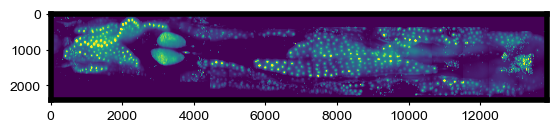

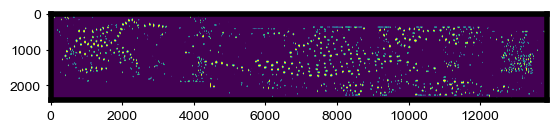

In [6]:
"""test mask"""
im = imread(r'/media/brandon/Data2/Brandon/fly_immune/Lightsheet_Z1/2025_06_10_gfp-rel_ecoli-hs-dtom_6hrs/all_mips/mip_larva_3.tif')
low_sigma=12
thresh = 0.0025

mask = create_mask(cp.asarray(im), thresh=thresh, low_sigma=low_sigma).get()

plt.figure()
plt.imshow(im, vmin=1200, vmax=5000)
plt.figure()
plt.imshow(mask)


In [58]:
#Image.fromarray(mask).save(r'/home/brandon/Documents/Code/diptericin-paper/figures/Supplemental_Figures/gfp-rel-fig/larva_3_mask.tif')

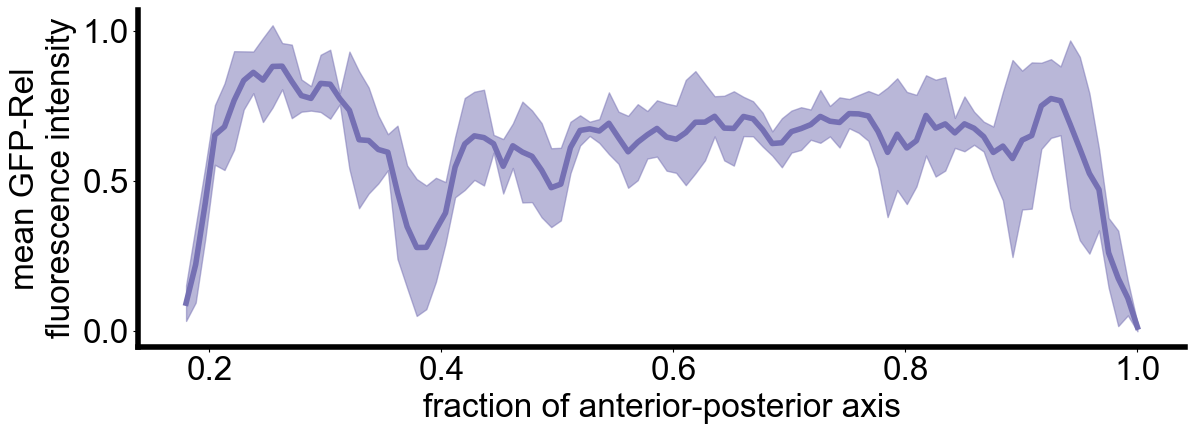

In [7]:
"""create averaged line dist across larvae"""
files = glob(gfp_rel_mips_dir + '/*.tif')
n_bins = 100
thresh = 0.0025
block_size = 128
normalize = True
color = np.array([117, 112, 179]) / 255
line_dist_arr = np.zeros((len(files), n_bins))
for i, file in enumerate(files):
    im = imread(file)
    line_dist_arr[i] = compute_line_dist(im, n_bins=n_bins)
    if normalize:
        line_dist_arr[i] = line_dist_arr[i] / np.max(line_dist_arr[i])
    
plt.figure(figsize=(12.05,  4.44))
m = np.mean(line_dist_arr, axis=0)
s = np.std(line_dist_arr, axis=0)
u = m + s
l = m - s
x = np.linspace(0.18, 1, n_bins)
plt.fill_between(x, l, u, color=color, alpha=0.5)
plt.plot(x, m, linewidth=linewidth, color=color)
plt.xlabel('fraction of anterior-posterior axis', fontsize=fontsize)
plt.ylabel('mean GFP-Rel\nfluorescence intensity', fontsize=fontsize)
plt.yticks([0, 0.5, 1])
ax = style_axes(plt.gca())
plt.tight_layout()

In [73]:
#plt.savefig(r'/home/brandon/Documents/Code/diptericin-paper/figures/Supplemental_Figures/gfp-rel-fig/gfp-rel_line_dists.pdf')